In [0]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp

from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output

In [67]:
df = pd.read_csv('./Mushrooms.csv')
df.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [68]:
df.shape

(8124, 23)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [70]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [71]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

Good, no missing data points. What's the varience of each of the features?

In [72]:
for feature in df.columns:
  unique = np.unique(df[feature])
  print(f'{feature}: {len(unique)} distinct values - {unique}')

class: 2 distinct values - ['e' 'p']
cap-shape: 6 distinct values - ['b' 'c' 'f' 'k' 's' 'x']
cap-surface: 4 distinct values - ['f' 'g' 's' 'y']
cap-color: 10 distinct values - ['b' 'c' 'e' 'g' 'n' 'p' 'r' 'u' 'w' 'y']
bruises: 2 distinct values - ['f' 't']
odor: 9 distinct values - ['a' 'c' 'f' 'l' 'm' 'n' 'p' 's' 'y']
gill-attachment: 2 distinct values - ['a' 'f']
gill-spacing: 2 distinct values - ['c' 'w']
gill-size: 2 distinct values - ['b' 'n']
gill-color: 12 distinct values - ['b' 'e' 'g' 'h' 'k' 'n' 'o' 'p' 'r' 'u' 'w' 'y']
stalk-shape: 2 distinct values - ['e' 't']
stalk-root: 5 distinct values - ['?' 'b' 'c' 'e' 'r']
stalk-surface-above-ring: 4 distinct values - ['f' 'k' 's' 'y']
stalk-surface-below-ring: 4 distinct values - ['f' 'k' 's' 'y']
stalk-color-above-ring: 9 distinct values - ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
stalk-color-below-ring: 9 distinct values - ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
veil-type: 1 distinct values - ['p']
veil-color: 4 distinct values - ['n' 

Hmmm.. that's interesting - it seems as all known mushrooms have the same veil-type. We can drop this feature then, it won't help us.

In [0]:
df.drop(['veil-type'], axis=1, inplace=True)

Before we continue, let's check if there are any duplicates in our data - meaning, do we know of two or more mushrooms with exactly the same features?

In [74]:
print(f'Known mushrooms: {len(df.index)}\nUnique mushrooms: {len(df.drop_duplicates().index)}')

Known mushrooms: 8124
Unique mushrooms: 8124


No, good. Wait! Are there any mushrooms with the same features but different classes?

In [75]:
print('Known mushrooms: {}\nMushrooms with same features: {}'.format(
    len(df.index), len(df.drop_duplicates(subset=df.drop(['class'], axis=1).columns).index)))

Known mushrooms: 8124
Mushrooms with same features: 8124


Ok, that's good. That's really good. Being unable to distinguish mushrooms can be deadly.

Time to start diving deeper into the data. Let's see if there's a feature that can a better notion about the mushromm's class. More formealy, we want to know if there's a certain feature that maximizes the information about the class. For this, we will use Theil's U, also known as the Uncertainty Coefficient.

In [0]:
def conditional_entropy(x, y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theil_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

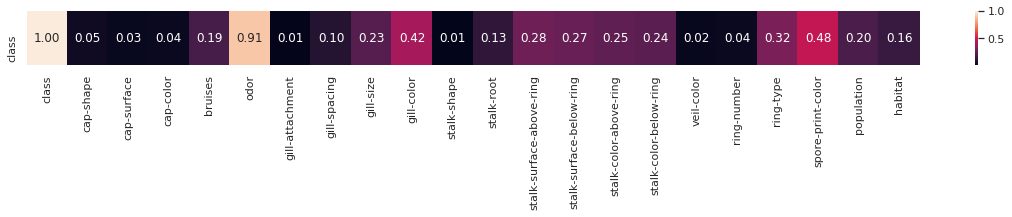

In [77]:
theilu = pd.DataFrame(index=['class'], columns=df.columns)
columns = df.columns

for i in range(len(columns)):
    u = theil_u(df['class'].tolist(), df[columns[i]].tolist())
    theilu.loc[:, columns[i]] = u

theilu.fillna(value=np.nan, inplace=True)
plt.figure(figsize=(20, 1))
sns.heatmap(theilu, annot=True, fmt='.2f')
plt.show()

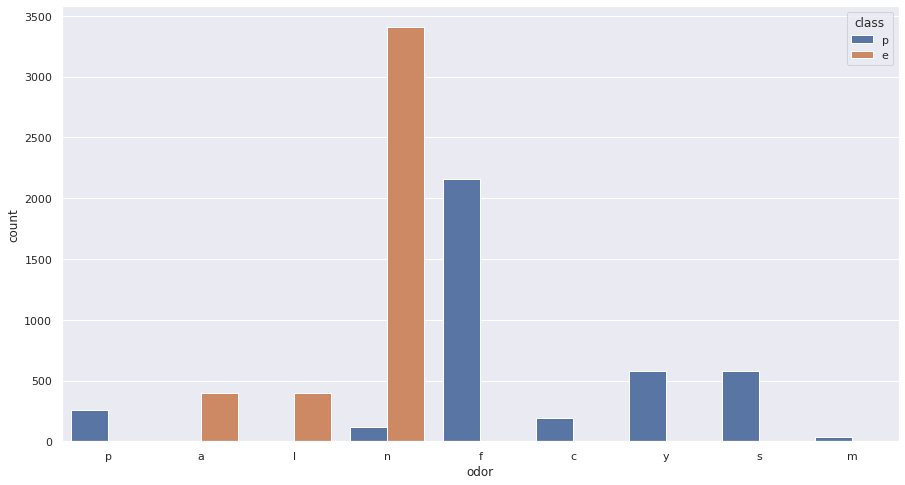

In [78]:
sns.countplot(x='odor', hue='class', data=df)

Ok, that's great! We can tell if a mushroom is ediable or not just by smelling it! But what about all those mushrooms with no odor (odor='n')? Let's do the same trick again, but this time only for the data of these mushrooms:

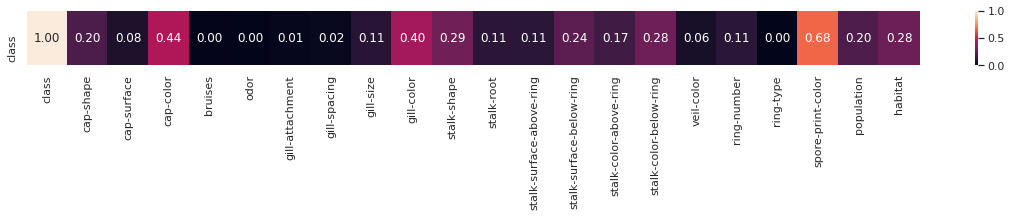

In [79]:
no_odor = df[df['odor'].isin(['n'])]
for i in range(len(columns)):
    u = theil_u(no_odor['class'].tolist(), no_odor[columns[i]].tolist())
    theilu.loc[:, columns[i]] = u

theilu.fillna(value=np.nan, inplace=True)
plt.figure(figsize=(20, 1))
sns.heatmap(theilu, annot=True, fmt='.2f')
plt.show()

ow the spore-print-color seems like a helpful feature:

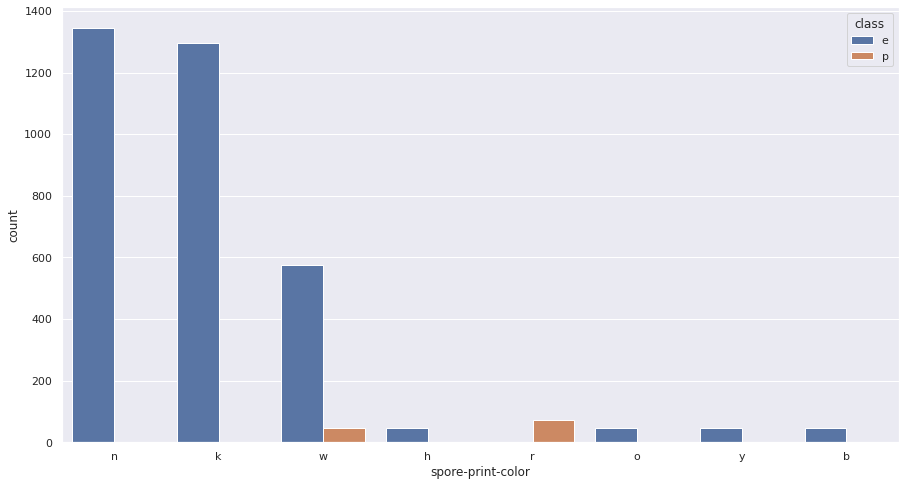

In [80]:
sns.countplot(x='spore-print-color', hue='class', data=no_odor)

Great success! We can tell odorless mushrooms apart by their spore color - unless it's white, then it's still ambiguous.

Let's see how many mushrooms are we already able telling if they're ediable or not:

In [81]:
no_odor_w = no_odor[no_odor['spore-print-color'].isin(['w'])]
(len(df.index) - len(no_odor_w.index)) / len(df.index)

0.9231905465288035

So we can now determine the class of 92% of the mushrooms we know of.

Let's summarize our findings:

* if the mushroom smells like almond (a) or anise (l), it's ediable.
* if it has no odor, check its spore color - if it's not green (r), it's ediable. If it's white, we're not sure.

ML Now

We can keep going like this, but 92% percent classified mushroom is enough to help you find some food in the woods - and you only to remeber two things.

For the remaining 8%, let's use a Decision Tree (well, you are in the forest, aren't you?). The tree will pretty mush do what we did so far - ask the right questions to slice the data in the best way for classifications. Let's see how many branches it needs to get to perfect classification. For this, we'll need to factorize the remaining data and use one-hot encoding.

In [82]:
factorized_nw = no_odor_w.copy()
for column in factorized_nw.columns.values:
    f, _ = pd.factorize(factorized_nw[column])
    factorized_nw.loc[:, column] = f

ohe = sp.OneHotEncoder()
X = factorized_nw.drop(['class'], axis=1)
y = factorized_nw['class'].tolist()
ohe.fit(X)
X = ohe.transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

for i in range(1, 6):
    tree = DecisionTreeClassifier(max_depth=i, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    print("Max depth: {} - accuracy:".format(i), accuracy_score(y_test, y_pred, normalize=True))

Max depth: 1 - accuracy: 0.967948717948718
Max depth: 2 - accuracy: 0.9871794871794872
Max depth: 3 - accuracy: 0.9935897435897436
Max depth: 4 - accuracy: 0.9935897435897436
Max depth: 5 - accuracy: 1.0


Seems like we got we wanted, and we only used 50% of the data for training - so we have half of the data as our test set. Let's see some more numbers:

In [83]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       291
           1       1.00      1.00      1.00        21

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312

[[291   0]
 [  0  21]]
